In [ ]:
# Predict the price of the Uber ride from a given pickup point to the agreed drop-off location.
# Perform following tasks:
# 1. Pre-process the dataset.
# 2. Identify outliers.
# 3. Check the correlation.
# 4. Implement linear regression and random forest regression models.
# 5. Evaluate the models and compare their respective scores like R2, RMSE, etc.
# Dataset link: https://www.kaggle.com/datasets/yasserh/uber-fares-datase

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Load the dataset
data = pd.read_csv("Uber.csv") 

data

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [2]:
# 1. Pre-process the dataset

# Remove unnecessary column
data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"])

# print(data)

missing_values = data.isnull().sum()
print("Missing values in the dataset:")
print(missing_values)

# Handle missing values
# We can choose to drop rows with missing values or fill them with appropriate values.

data.dropna(inplace=True)

# To fill missing values with the mean value of the column:
# data.fillna(data.mean(), inplace=True)

# Ensure there are no more missing values
missing_values = data.isnull().sum()
print("Missing values after handling:")
print(missing_values)

# 2. Identify outliers


Missing values in the dataset:
Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64
Missing values after handling:
Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


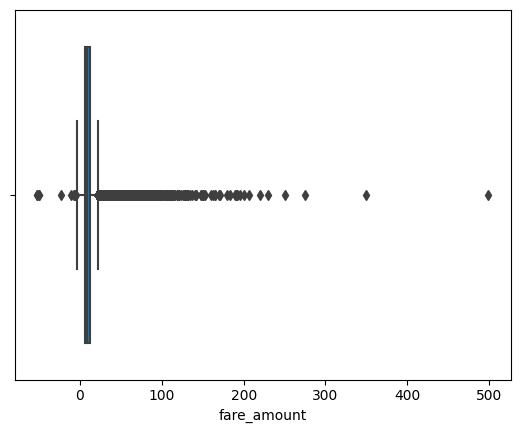

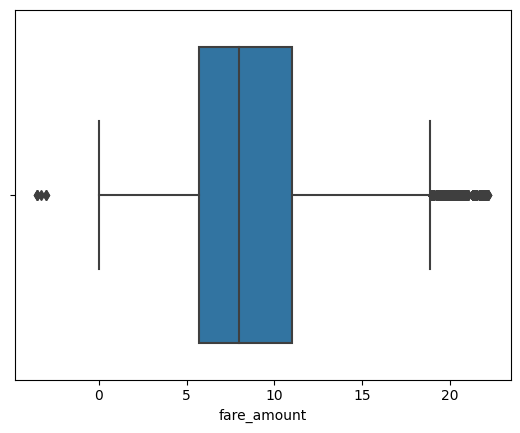

In [3]:

# visualization to detect outliers.
sns.boxplot(x=data["fare_amount"])
plt.show()

# Calculate the IQR for the 'fare_amount' column
Q1 = data["fare_amount"].quantile(0.25)
Q3 = data["fare_amount"].quantile(0.75)
IQR = Q3 - Q1

# Define a threshold (e.g., 1.5 times the IQR) to identify outliers
threshold = 1.5
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR



# Remove outliers
data_no_outliers = data[(data["fare_amount"] >= lower_bound) & (data["fare_amount"] <= upper_bound)]

# Visualize the 'fare_amount' distribution without outliers
sns.boxplot(x=data_no_outliers["fare_amount"])
plt.show()

Unnamed: 0              Axes(0.125,0.786098;0.352273x0.0939024)
fare_amount          Axes(0.547727,0.786098;0.352273x0.0939024)
pickup_longitude        Axes(0.125,0.673415;0.352273x0.0939024)
pickup_latitude      Axes(0.547727,0.673415;0.352273x0.0939024)
dropoff_longitude       Axes(0.125,0.560732;0.352273x0.0939024)
dropoff_latitude     Axes(0.547727,0.560732;0.352273x0.0939024)
passenger_count         Axes(0.125,0.448049;0.352273x0.0939024)
dtype: object

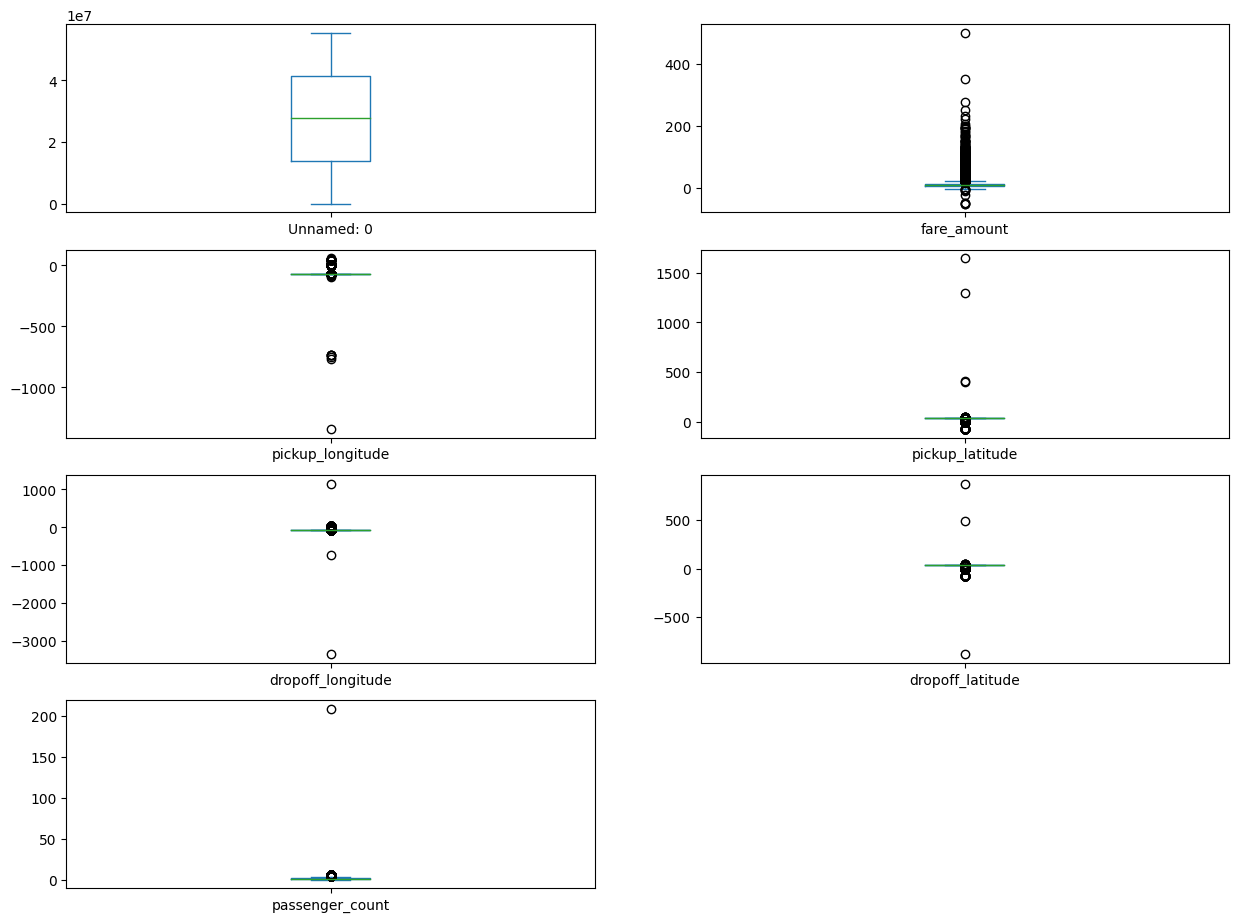

In [4]:
data.plot(kind="box",subplots=True, layout=(7, 2), figsize=(15, 20))

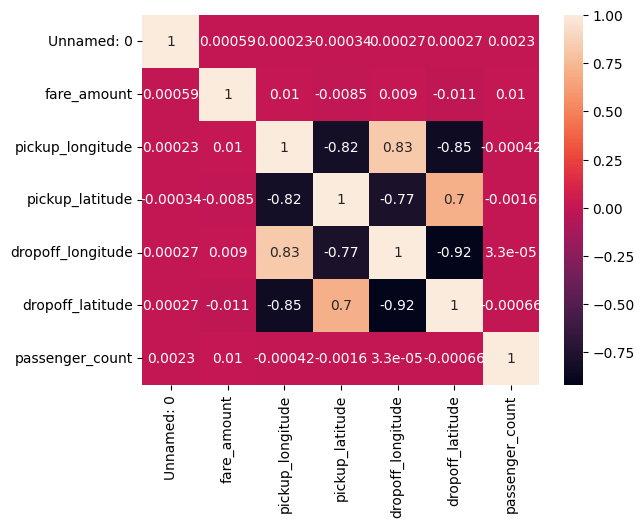

In [5]:
# 3. Check the correlation
# Determine the correlation between features and the target variable (fare_amount).
correlation_matrix = data.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [6]:
data.keys()

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [7]:
# 4. Implement linear regression and random forest regression models
# Split the data into features and target variable
X = data[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']]
y = data['fare_amount']  #Target
y

0          7.5
1          7.7
2         12.9
3          5.3
4         16.0
          ... 
199995     3.0
199996     7.5
199997    30.9
199998    14.5
199999    14.1
Name: fare_amount, Length: 199999, dtype: float64

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Create and train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [16]:
# Create and train the random forest regression model
rf_model = RandomForestRegressor(n_estimators=50, random_state=42,verbose=1)
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  6.5min finished


RandomForestRegressor(n_estimators=50, random_state=42, verbose=1)

In [17]:
# 5. Evaluate the models
# Predict the values
y_pred_lr = lr_model.predict(X_test)
y_pred_lr
print("Linear Model:",y_pred_lr)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Model:", y_pred_rf)

Linear Model: [11.29237916 11.29171388 11.5718662  ... 11.29183291 11.43252639
 11.29190248]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Random Forest Model: [ 8.878   5.108  12.698  ...  7.2194 11.024   8.38  ]


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.8s finished


In [18]:
# Calculate R-squared (R2) and Root Mean Squared Error (RMSE) for both models
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

In [19]:
# Compare the scores
print("Linear Regression - R2:", r2_lr)
print("Linear Regression - RMSE:", rmse_lr)

Linear Regression - R2: 0.00034152697863043535
Linear Regression - RMSE: 10.197470623964248


In [20]:
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest Regression R2:", r2_rf)
print("Random Forest Regression RMSE:",rmse_rf)

Random Forest Regression R2: 0.6975220368934889
Random Forest Regression RMSE: 5.609362504141667


In [ ]:
# Overall Analysis

# The Random Forest Regression model has significantly improved the predictive performance. 
# An R-squared (R2) value of approximately 0.701 and a Root Mean Squared Error (RMSE) 
# of approximately 5.575 indicate that the Random Forest model is capturing a substantial portion 
# of the variance in the target variable and providing more accurate predictions compared to the linear regression model.

In [ ]:
# Predict the price of the Uber ride from a given pickup point to the agreed drop-off location.
# Perform following tasks:
# 1. Pre-process the dataset.
# 2. Identify outliers.
# 
# 4. Implement linear regression and random forest regression models.
# 5. Evaluate the models and compare their respective scores like R2, RMSE, etc.

In [1]:
import pandas as pd
import numpy as np

dataset=pd.read_csv("Uber.csv")
print(dataset)

        Unnamed: 0                            key  fare_amount  \
0         24238194    2015-05-07 19:52:06.0000003          7.5   
1         27835199    2009-07-17 20:04:56.0000002          7.7   
2         44984355   2009-08-24 21:45:00.00000061         12.9   
3         25894730    2009-06-26 08:22:21.0000001          5.3   
4         17610152  2014-08-28 17:47:00.000000188         16.0   
...            ...                            ...          ...   
199995    42598914   2012-10-28 10:49:00.00000053          3.0   
199996    16382965    2014-03-14 01:09:00.0000008          7.5   
199997    27804658   2009-06-29 00:42:00.00000078         30.9   
199998    20259894    2015-05-20 14:56:25.0000004         14.5   
199999    11951496   2010-05-15 04:08:00.00000076         14.1   

                pickup_datetime  pickup_longitude  pickup_latitude  \
0       2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1       2009-07-17 20:04:56 UTC        -73.994355        40.728225 

In [2]:
#preprocessing
dataset['pickup_datetime']=pd.to_datetime(dataset["pickup_datetime"])
print(dataset["pickup_datetime"])

0        2015-05-07 19:52:06+00:00
1        2009-07-17 20:04:56+00:00
2        2009-08-24 21:45:00+00:00
3        2009-06-26 08:22:21+00:00
4        2014-08-28 17:47:00+00:00
                    ...           
199995   2012-10-28 10:49:00+00:00
199996   2014-03-14 01:09:00+00:00
199997   2009-06-29 00:42:00+00:00
199998   2015-05-20 14:56:25+00:00
199999   2010-05-15 04:08:00+00:00
Name: pickup_datetime, Length: 200000, dtype: datetime64[ns, UTC]


In [3]:
#null values before preprocessing

print("null values befor")
print(dataset.isnull().sum())

dataset.dropna(inplace=True)


print("null values after")
print(dataset.isnull().sum())

null values befor
Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64
null values after
Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


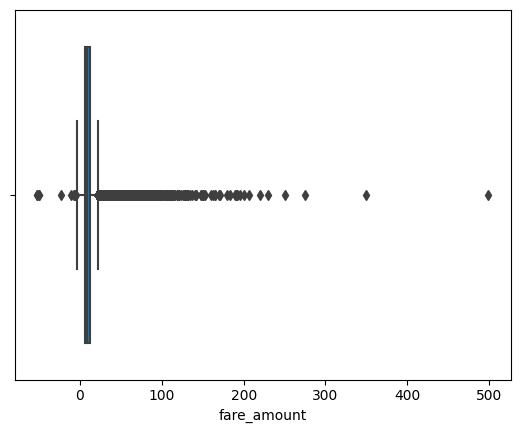

6.0 12.5 6.5


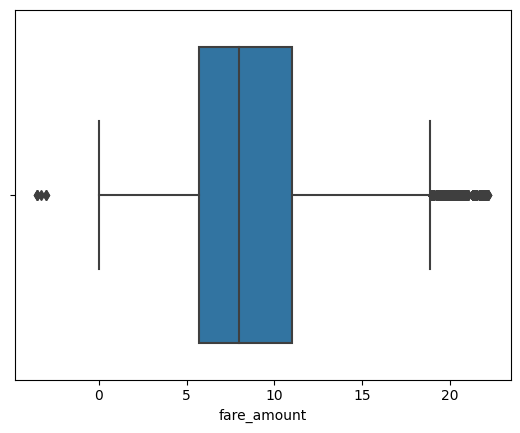

In [5]:
#outliers
import matplotlib.pyplot  as plt
import seaborn as sns

sns.boxplot(x=dataset['fare_amount'])
plt.show()

#interquartile range

q1=dataset["fare_amount"].quantile(0.25)
q3=dataset["fare_amount"].quantile(0.75)

iqr=q3-q1
threshold=1.5
lower_bound=q1-threshold*iqr
upper_bound=q3+threshold*iqr
print(q1,q3,iqr)


#removing outliers

no_outliers=dataset[(dataset["fare_amount"]>=lower_bound) & (dataset["fare_amount"]<=upper_bound)]
sns.boxplot(x=no_outliers["fare_amount"])
plt.show()

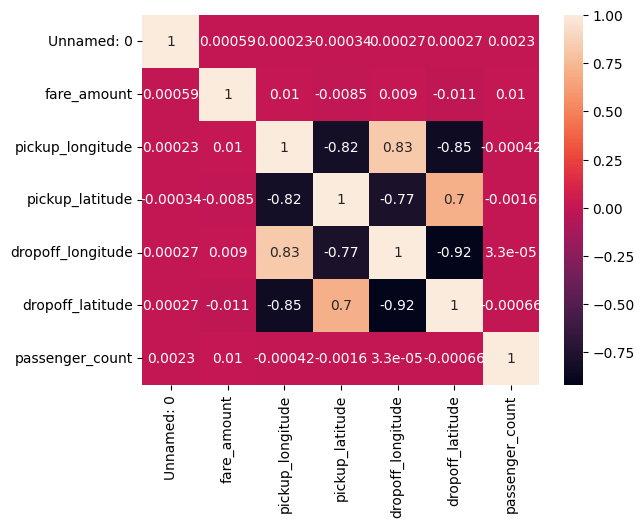

In [6]:
#3. Check the correlation.
corr_matrix=dataset.corr(numeric_only=True)
sns.heatmap(corr_matrix,annot=True)
plt.show()


In [10]:
from sklearn.model_selection import train_test_split
x=dataset.drop(columns=["Unnamed: 0","key","pickup_datetime","fare_amount"],axis=1)
y=dataset["fare_amount"]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
x_train

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
157134,-73.988077,40.765627,-73.984463,40.748312,1
116607,-74.004982,40.746201,-73.989129,40.735168,1
78783,-73.988993,40.777060,-73.977211,40.784552,3
103093,-73.951705,40.778330,-73.956050,40.777560,2
162400,-73.969677,40.749052,-73.776282,40.645697,5
...,...,...,...,...,...
119880,-73.977408,40.745482,-74.008602,40.732757,5
103695,-74.001627,40.739437,-73.996898,40.720352,5
131933,-73.987095,40.718023,-73.945118,40.708252,1
146868,-73.988613,40.755773,-73.978551,40.764907,1


In [11]:
#linear regression model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
lr_model=LinearRegression() 
lr_model.fit(x_train,y_train)
y_pred_lr=lr_model.predict(x_test)
y_pred_lr

r2Score=r2_score(y_test,y_pred_lr)
rmse=np.sqrt(mean_squared_error(y_test,y_pred_lr))
print(r2Score,rmse)



0.00034152697863043535 10.197470623964248


In [12]:
from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import r2_score,mean_squared_error
rf_model=RandomForestRegressor(n_estimators=100,random_state=42) 
rf_model.fit(x_train,y_train)
y_pred_rf=rf_model.predict(x_test)
y_pred_rf


KeyboardInterrupt: 